# Chart: Boston Daily Temperatures plus Facebook Prophet Forecast


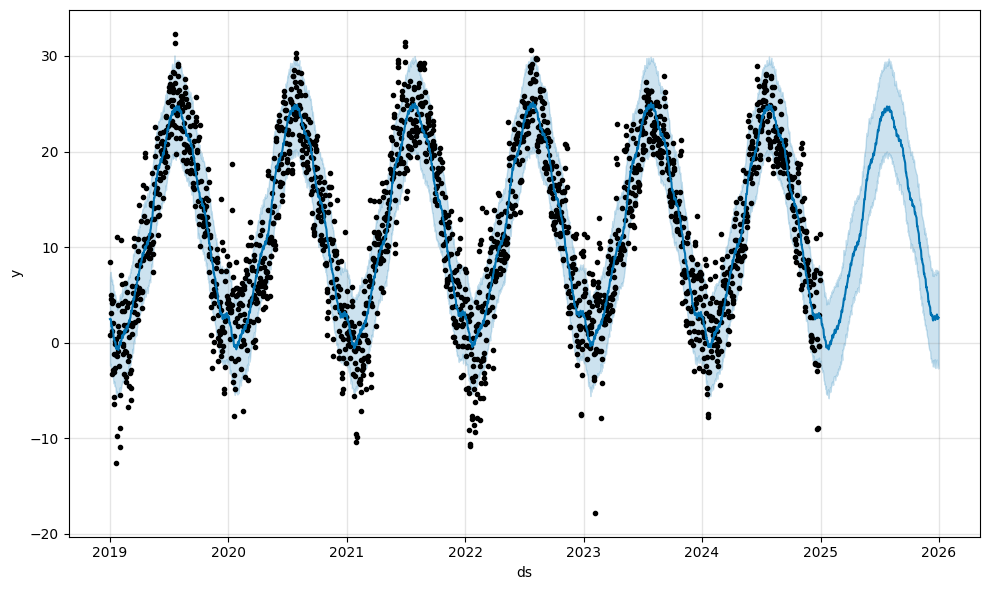

In [ ]:
# https://chatgpt.com/share/6845efdb-f5a4-800c-b03a-442128854276

import logging
import time

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prophet import Prophet
from google.colab import userdata

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

data = []
for year in range(2019, 2025):
    # ─── Configuration ─────────────────────────────────────────────────────────────
    STATION = "GHCND:USW00014739" # Boston Logan International Airport
    END_DATE = f"{year:04d}-12-31" # datetime.today().date()
    START_DATE = f"{year:04d}-01-01" # END_DATE - timedelta(days=365)
    BASE_URL = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

    # ─── Fetch data ────────────────────────────────────────────────────────────────
    headers = {"Token": userdata.get("NCDC_API_KEY")}
    params = {
        "datasetid": "GHCND",
        "datatypeid": "TAVG",  # daily average temp (in tenths °C)
        "stationid": STATION,
        "startdate": START_DATE, #.isoformat(),
        "enddate": END_DATE, #.isoformat(),
        "limit": 1000,         # max per request; you may need to page if >1000 days
        "units": "metric"      # returns °C
    }

    resp = requests.get(BASE_URL, headers=headers, params=params)
    resp.raise_for_status()

    data.extend(resp.json().get("results", []))
    time.sleep(5.0)

# ─── Process ─────────────────────────────────────────────────────────────────
df = pd.DataFrame(data)
df["ds"] = pd.to_datetime(df["date"]).dt.date
df["y"] = df["value"]  # already in °C
df = df.sort_values("ds")

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)